# 1. Instalacije i importanje

In [ ]:
pip install seaborn

In [ ]:
pip install pandas

In [ ]:
pip install plotly

In [ ]:
pip install missingno

In [ ]:
pip install geopandas

In [ ]:
pip install numpy

In [113]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

In [170]:
# Skrivanje warninga
import warnings
warnings.filterwarnings('ignore')

# 2. Izvlačenje podataka iz dataseta u kojem se nalaze podaci o potrošnji i uporabi energije po državama kroz godine

In [154]:
wec = pd.read_csv("./datasets/world_energy_consumption.csv")

In [155]:
# Iz dataseta uzmemo stupce koji označavaju pojedine izvore iz kojih se dobije električna energija
izvori = ['coal_electricity','oil_electricity','gas_electricity','hydro_electricity','nuclear_electricity','wind_electricity','solar_electricity']

# Sortiramo po godini i državi, pa od pojedinih izvora izvučemo omjer tog izvora u odnosu na ukupnu proizvodnju električne energije u postotcima
izvoriPoDrzaviIGodini = wec[['year','country']]
wec['ukupno'] = wec[izvori].sum(axis=1)
for i in izvori:
    izvoriPoDrzaviIGodini[f"{i}%"] = (wec[i]/wec['ukupno']) * 100

# Uzmemo samo godine ovog tisućljeća
izvoriPoDrzaviIGodini = izvoriPoDrzaviIGodini[izvoriPoDrzaviIGodini['year']>=2000]

# 3. Tipovi izvora električne energije u Hrvatskoj i Europi

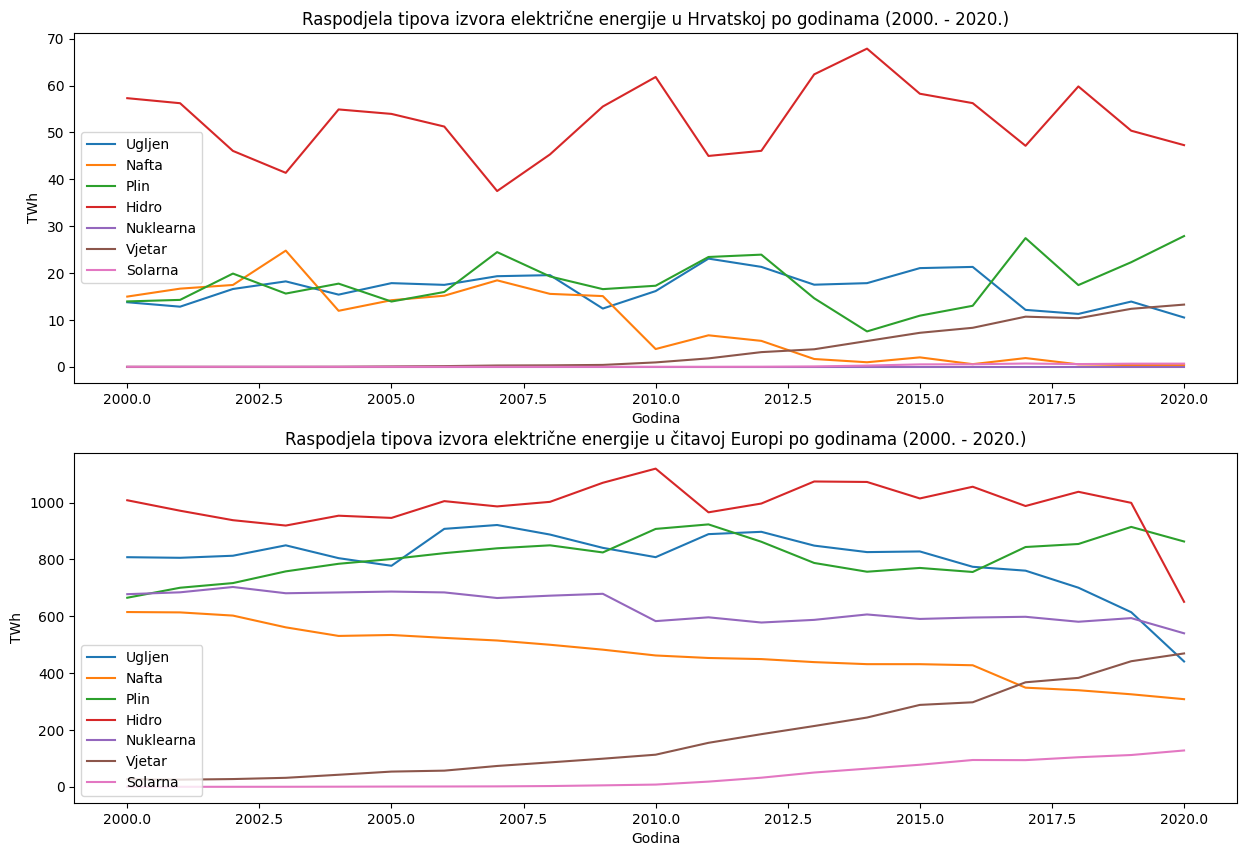

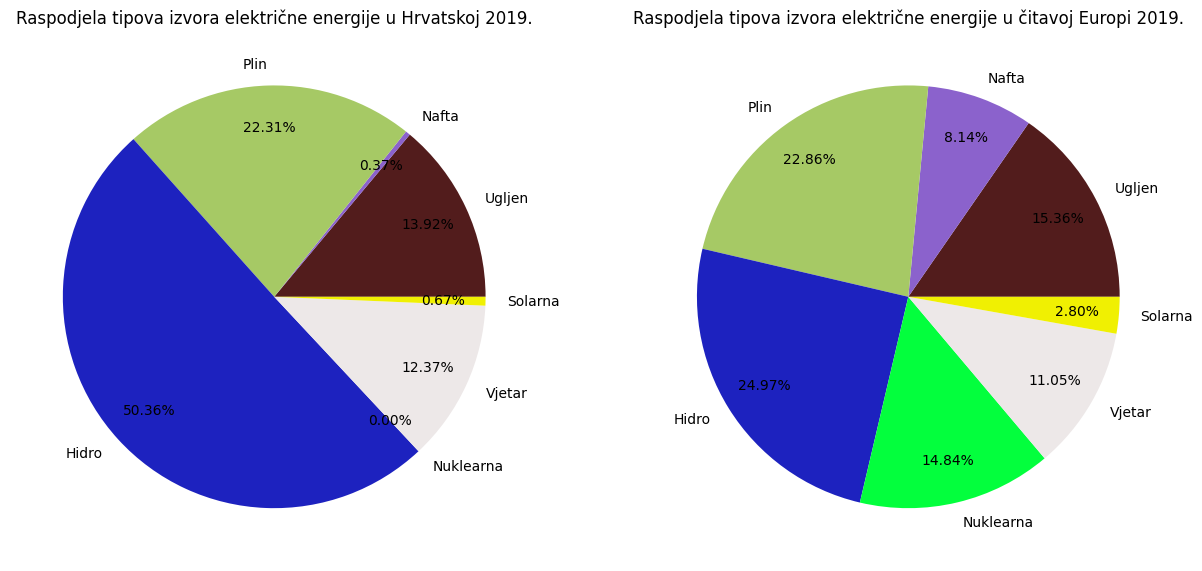

In [179]:
# Izdvojimo podatke za Hrvatsku
hrvatska = izvoriPoDrzaviIGodini[izvoriPoDrzaviIGodini['country']=='Croatia'].groupby('year').sum()

# Za Europu koristimo dataset 'Countries-Continents.csv' koji sadrži parove kontinent-država za sve države svijeta
# Zbrojimo ukupnu potrošnju svih europskih država u teravat satima
kontinenti = pd.read_csv('./datasets/Countries-Continents.csv')
europa = izvoriPoDrzaviIGodini.loc[izvoriPoDrzaviIGodini['country']
    .isin(kontinenti[kontinenti['Continent'] == 'Europe']['Country'])].groupby('year').sum()


# Nazivi za pojedine grafove i boje koje se koriste u grafovima
naziviGrafova = {'Ugljen':'coal_electricity', 'Nafta': 'oil_electricity', 'Plin' : 'gas_electricity','Hidro' : 'hydro_electricity',
    'Nuklearna' : 'nuclear_electricity','Vjetar' : 'wind_electricity','Solarna' : 'solar_electricity'}
bojeTipovaEnergije = ['#521c1c','#8b62cc','#a6c965','#1d22bf','#03ff3d','#ede8e8','#f0f002']

# Pomoć pri crtanju grafova
drzave = [hrvatska, europa]
imeDržaveZaNaslovGrafa = ['Hrvatskoj', 'čitavoj Europi']


# Linijski grafovi koji prikazuju tipove izvora električne energije za Hrvatsku i Europu kroz godine
fig, ax = plt.subplots(2, figsize=(15, 10))
br = 0
for drzava in drzave:
    ax[br].plot(drzava, label = naziviGrafova)
    ax[br].set_title(f"Raspodjela tipova izvora električne energije u {imeDržaveZaNaslovGrafa[br]} po godinama (2000. - 2020.)")
    ax[br].set_ylabel('TWh')
    ax[br].set_xlabel('Godina')
    ax[br].legend()
    br = br+1

# Pie chartovi koji prikazuju raspodjelu tipova izvora električne energije u Hrvatskoj i Europi 2019. godine
fig, ax =  plt.subplots(1, 2, figsize=(15, 10))
br = 0
for drzava in drzave:
    pieChart=drzava[(drzava.index.values == 2019)]
    ax[br].pie(pieChart.iloc[0].values, colors=bojeTipovaEnergije, labels=naziviGrafova, autopct='%1.2f%%', pctdistance=0.8)
    ax[br].set_title(f"Raspodjela tipova izvora električne energije u {imeDržaveZaNaslovGrafa[br]} 2019.")
    ax[br].set_alpha(0.1)
    br = br+1

plt.show()

# 4. Potrošnja energije iz obnovljivih izvora u Hrvatskoj i svijetu

In [157]:
# Označavanje izvora energije koji su obnovljivi i dohvaćanje podataka o njihovoj potrošnji
potrosnja = ["iso_code","country", "year", "renewables_consumption","other_renewable_consumption","hydro_consumption","solar_consumption","wind_consumption", "population"]
potrosnja_obnovljivi = ["hydro_consumption","solar_consumption","wind_consumption","other_renewable_consumption"]
potrosnja_df = wec[potrosnja]
# Potrebno je promijeniti ime stupca 'iso_code' u 'iso_a3' zbog kasnijeg korištenja shapefile datoteke za prikaz karte svijeta
potrosnja_df.rename({"iso_code":"iso_a3"}, axis=1, inplace=True)

#Uzmemo podatke iz razdoblja 2000. - 2019.
godine = potrosnja_df["year"].isin(range(2000,2019))
potrosnja_df = potrosnja_df[godine]
bar = potrosnja_df.groupby('year')[potrosnja_obnovljivi].sum()
bar.reset_index(level=0, inplace=True)

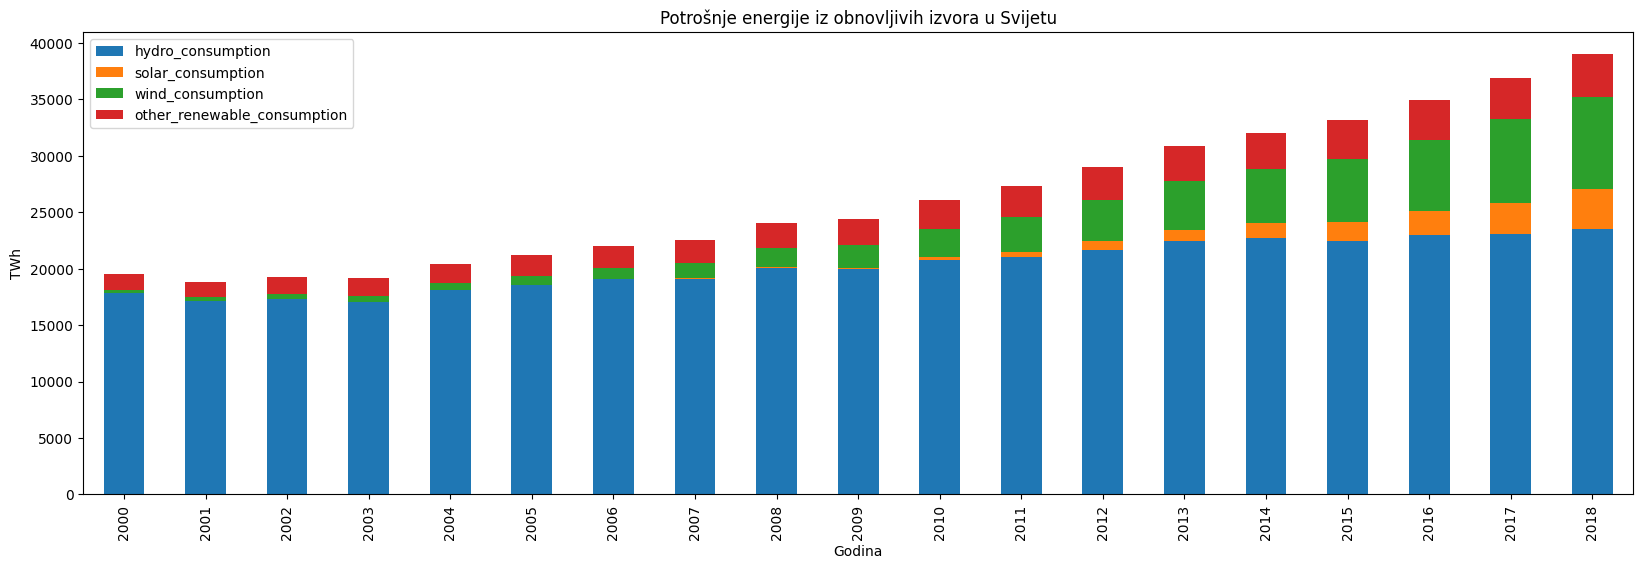

In [162]:
# Barplot koji prikazuje potrošnju energije iz obnovljivih izvora u ovom tisućljeću za cijeli svijet
bar.plot(x='year', xlabel='Godina', ylabel='TWh', kind='bar', stacked=True, figsize=(20,6),
        title='Potrošnje energije iz obnovljivih izvora u Svijetu');

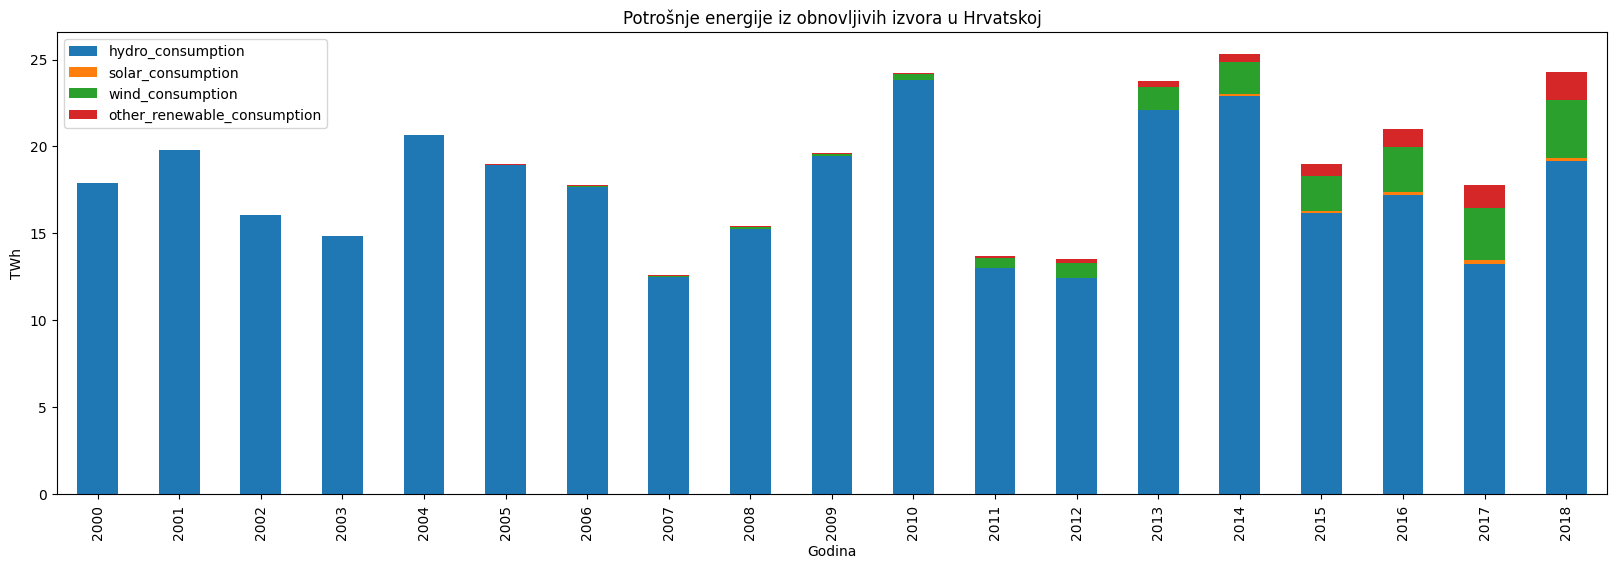

In [163]:
# Barplot koji prikazuje potrošnju energije iz obnovljivih izvora u ovom tisućljeću samo za Hrvatsku
bar2 = potrosnja_df[potrosnja_df['country']=='Croatia'].groupby('year')[potrosnja_obnovljivi].sum()
bar2.reset_index(level=0, inplace=True)

bar2.plot(x='year', xlabel='Godina', ylabel='TWh', kind='bar', stacked=True, figsize=(20,6),
        title='Potrošnje energije iz obnovljivih izvora u Hrvatskoj');

In [120]:
# Iz grafova se vidi se da u Hrvatskoj i u svijetu raste potrošnja energije dobivene od sunca, vjetra, i drugih obnovljivih izvora energije.

# 5. Potrošnja energije iz obnovljivih izvora po državama

In [121]:
# Učitavanje shapefile datoteke koja sadrži kartu svijeta
drzave = gpd.read_file("./all_countries_shapefile/all_countries.shp")
karta = drzave[["iso_a3","geometry"]]

# Merge shapefilea sa podacima o potrošnji energije
kartaPotrosnjeEnergije = potrosnja_df.merge(karta, on='iso_a3')
obnovljivi_gdf = gpd.GeoDataFrame(
    kartaPotrosnjeEnergije, geometry=kartaPotrosnjeEnergije["geometry"])

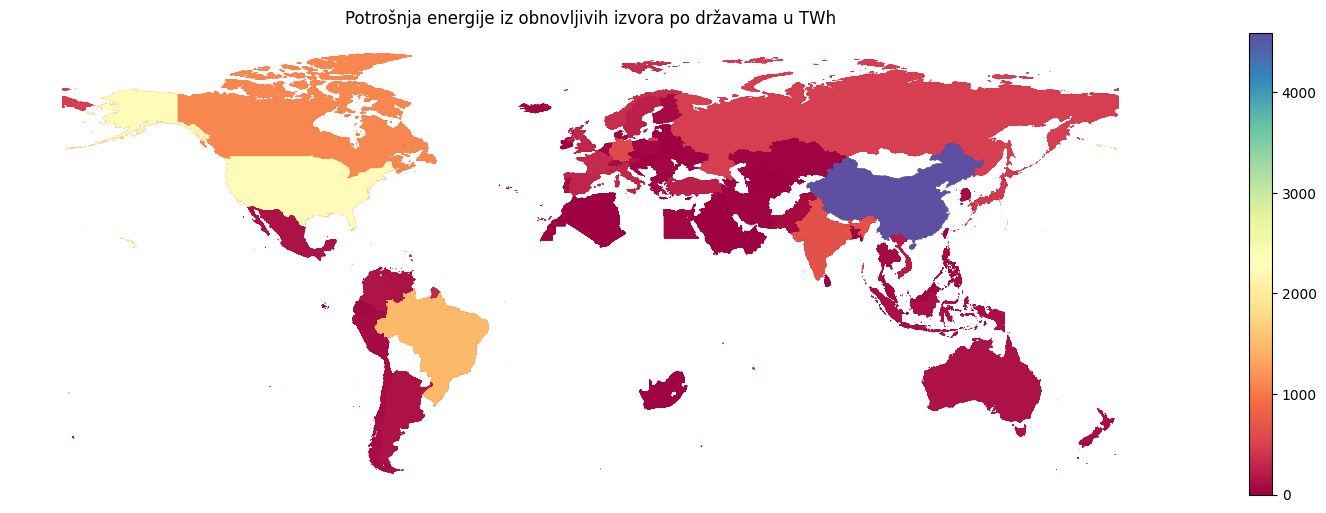

In [164]:
# Izrada grafa na karti svijeta
fig, ax = plt.subplots(1, figsize=(20, 6))
ax.axis('off')
ax.set_title('Potrošnja energije iz obnovljivih izvora po državama u TWh')

obnovljivi_gdf.plot(column='renewables_consumption', cmap="Spectral", ax=ax, legend=True);

# 6. Potrošnja energije iz obnovljivih izvora po europskim državama

In [165]:
# Označavanje izvora energije koji su obnovljivi i dohvaćanje podataka o njihovoj potrošnji
potrosnja = ["country", "year", "other_renewable_consumption","hydro_consumption","solar_consumption","wind_consumption"]
potrosnja_obnovljivi = ["hydro_consumption","solar_consumption","wind_consumption","other_renewable_consumption"]
potrosnja_df = wec[potrosnja]

# Dohvaćanje podataka o europskim državama u razdoblju od 2000. do 2019.
europa = kontinenti[kontinenti['Continent'] == 'Europe']['Country']
godine = potrosnja_df["year"].isin(range(2000,2019))
potrosnja_df = potrosnja_df.loc[potrosnja_df['country'].isin(europa)]
potrosnja_df = potrosnja_df[godine]

# Izbacivanje država kojima su sve vrijednosti jednake nuli
potrosnja_df=potrosnja_df[potrosnja_df!=0].dropna()

# Zbrajanje potrošnje svih energija obnovljivih izvora
potrosnja_df['ukupno'] = 0
for izvor in potrosnja_obnovljivi:
    potrosnja_df['ukupno'] = potrosnja_df['ukupno'] + potrosnja_df[izvor]

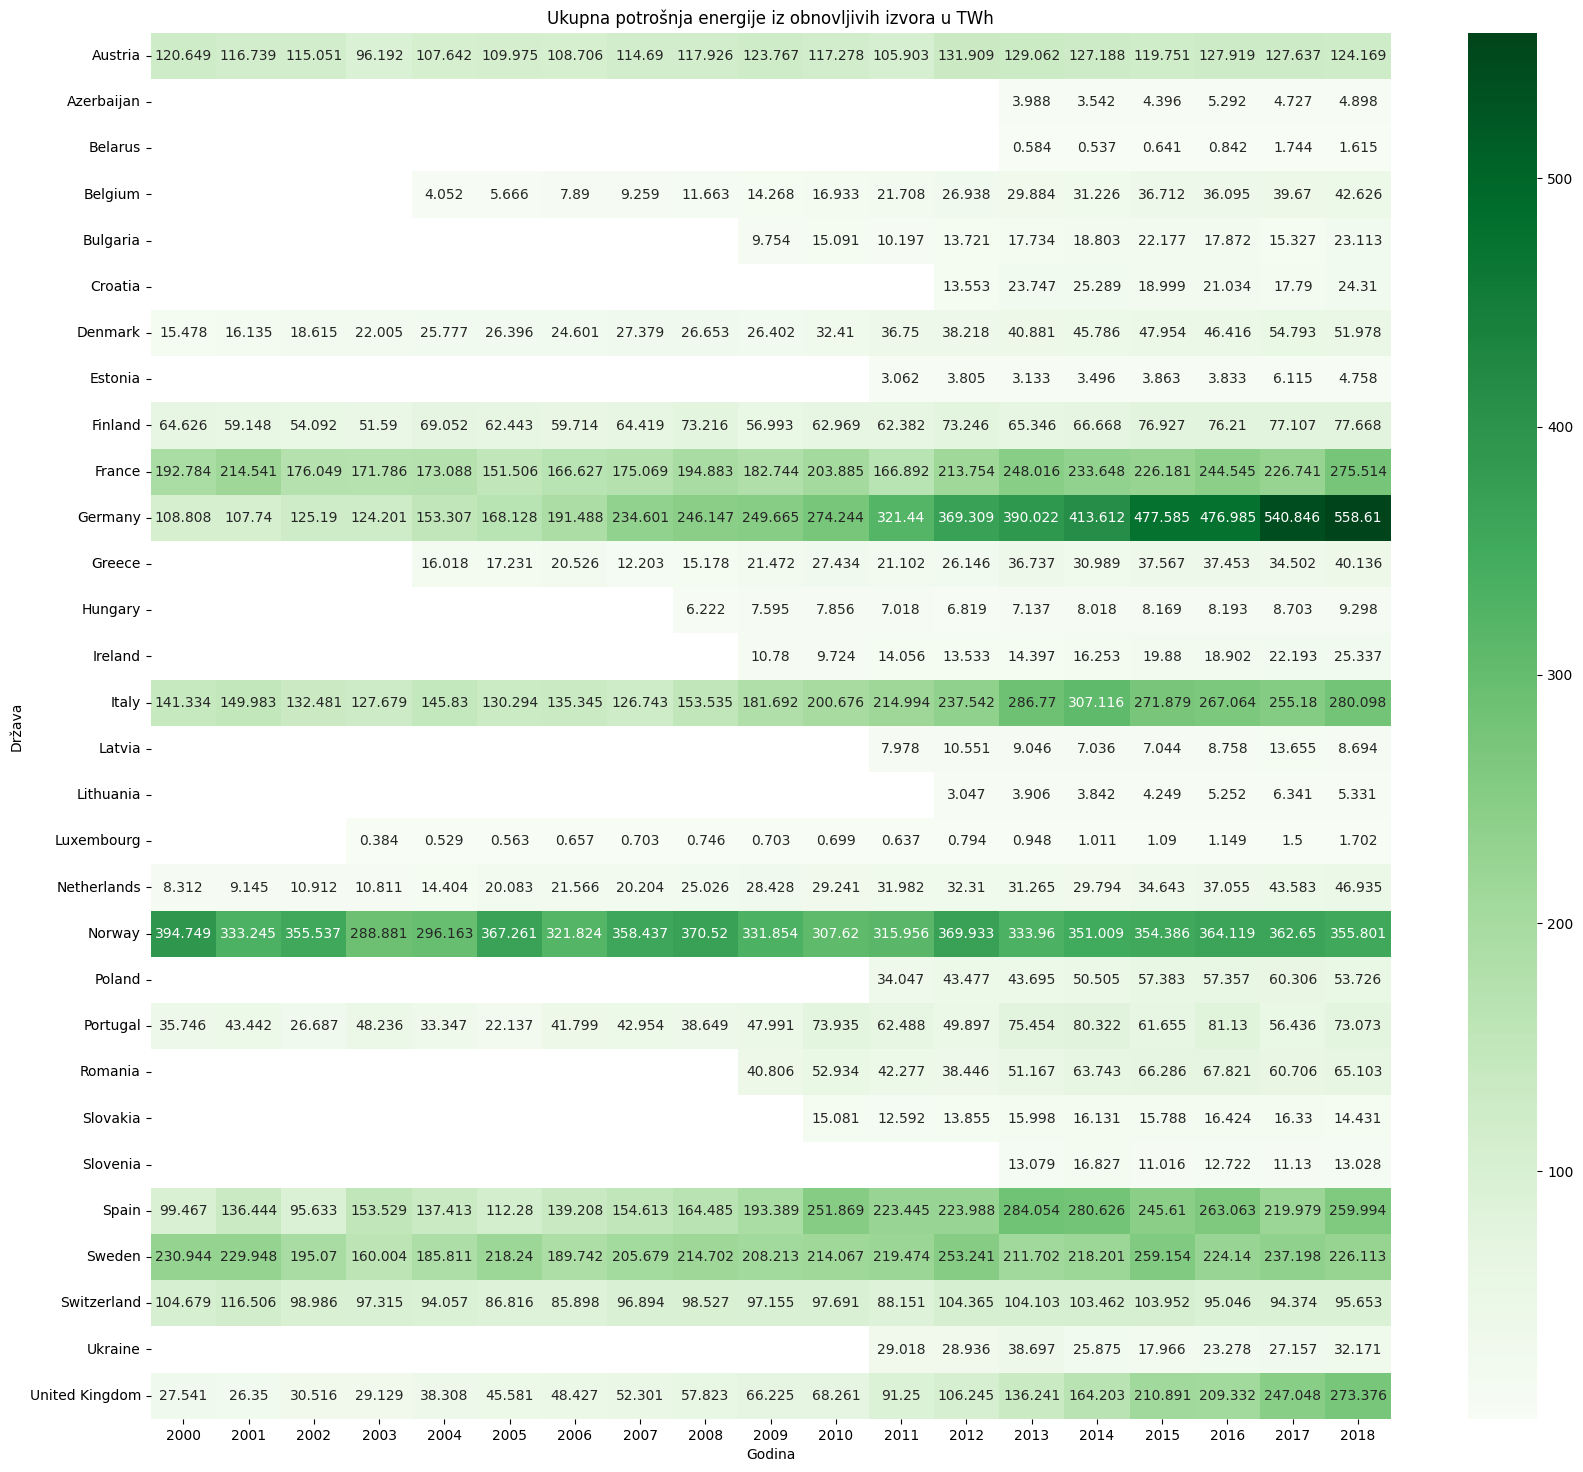

In [166]:
# Izrada heatmape koja prikazuje odnos države, godine, i zbroja potrošnje svih energija obnovljivih izvora
plt.figure(figsize=(20, 18))

graf = sns.heatmap(pd.crosstab(potrosnja_df['country'], potrosnja_df['year'], values=potrosnja_df['ukupno'], 
    aggfunc='sum'), annot=True, cmap = 'Greens', fmt='g')
    
plt.title('Ukupna potrošnja energije iz obnovljivih izvora u TWh')
plt.xlabel("Godina")
plt.ylabel("Država");

# 7. Globalna potrošnja energije iz obnovljivih izvora kroz godine

In [167]:
# Kao i ranije, označimo izvora energije koji su obnovljivi i dohvatimo podatke o njihovoj potrošnji
potrosnja = ["country", "year", "other_renewable_consumption","hydro_consumption","solar_consumption","wind_consumption"]
potrosnja_df = wec[potrosnja]
potrosnja_obnovljivi = ["hydro_consumption","solar_consumption","wind_consumption","other_renewable_consumption"]

# Izbacivanje država kojima su sve vrijednosti u nekoj godini jednake nuli
potrosnja_df = potrosnja_df[potrosnja_df != 0].dropna()

# Za svaki izvor uklanjamo 1% najviših i 1% najnižih vrijednosti zbog točnijeg prikaza grafova
for izvor in potrosnja_obnovljivi:
    potrosnja_df = potrosnja_df[potrosnja_df[izvor] < potrosnja_df[izvor].quantile(0.99)]
    potrosnja_df = potrosnja_df[potrosnja_df[izvor] > potrosnja_df[izvor].quantile(0.01)]

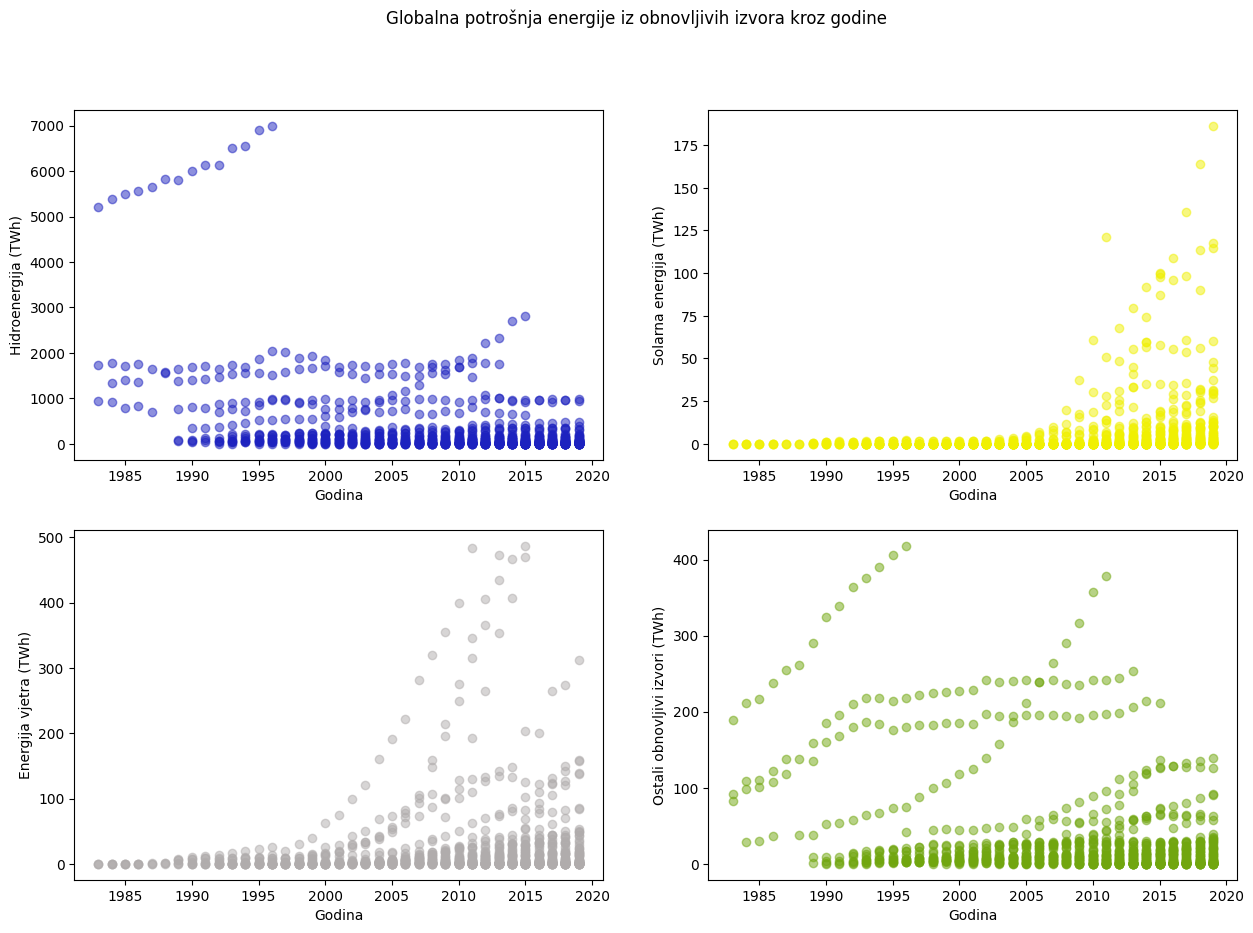

In [171]:
# Određivanje izvora koje ćemo koristiti i boja koje će se koristiti za određene izvore u grafu
naziviTipovaEnergije = ['Hidroenergija', 'Solarna energija', 'Energija vjetra', 'Ostali obnovljivi izvori']
bojeTipovaEnergije = ['#1d22bf','#f0f002','#b0acac','#71a60f']

# Izradimo scatter graf koji prikazuje potrošnju energije za svaki od četiri 
# tipa obnovljivih izvora u TWh po godinama za pojedine države 
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
plt.suptitle('Globalna potrošnja energije iz obnovljivih izvora kroz godine')

izvor = 0
for i in range(0, 2):
    for j in range(0, 2):
        ax[i, j].scatter(data=potrosnja_df, x='year', y=potrosnja_obnovljivi[izvor], 
            alpha=0.5, color=bojeTipovaEnergije[izvor])
        ax[i, j].set_ylabel(f'{naziviTipovaEnergije[izvor]} (TWh)')
        ax[i, j].set_xlabel('Godina')
        izvor = izvor+1

In [169]:
# Iz grafova vidimo da je na globalnoj razini porasla potrošnja energije iz obnovljivih izvora za sve navedene izvore, posebno u zadnjem
# desetljeću za energiju sunca i vjetra.